In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import itertools
import os

## Qutrit Gates

In [13]:
def x1_qutrit(q0, q1):
    """Applies X1 gate to a qutrit encoded in qubits (q0, q1)."""
    qc = QuantumCircuit(2)
    
    # Swap 00->01, 01->10, 10->00
    # Efficient sequence using CX and X gates
    qc.cx(q1, q0)
    qc.cx(q0, q1)
    qc.x(q0)
    
    return qc

def x2_qutrit(q0, q1):
    """Applies X2 gate to a qutrit encoded in qubits (q0, q1)."""
    qc = QuantumCircuit(2)
    
    # Reverse X1 logic
    qc.x(q0)
    qc.cx(q0, q1)
    qc.cx(q1, q0)
    
    return qc

X = [x1_qutrit(0, 1).to_instruction(label='X1'), x2_qutrit(0, 1).to_instruction(label='X2')]


def z1_qutrit(q0, q1):
    """Z1: applies phase ω to |01⟩, ω² to |10⟩."""
    qc = QuantumCircuit(2)

    omega = np.exp(2j * np.pi / 3)
    qc.p(np.angle(1), q1)       # |01⟩
    qc.p(np.angle(-1), q0)    # |10⟩
    
    return qc


Z = [z1_qutrit(0, 1).to_instruction(label='Z1')]

## Qutrit Embedded Dense Coding Scheme

In [14]:
#Create Entanglement 
# Create a 4-qubit circuit (2 qutrits, each encoded in 2 qubits)
qc = QuantumCircuit(3)

# Step 1: Hadamard on LSB of qutrit 0 (qubit 1)
qc.h(0)

# Step 2: CNOT from qubit 1 → qubit 3 (LSBs of both qutrits)
qc.cx(0, 2)


qc.barrier()

qc.append(Z[0], [0, 1])
qc.append(X[0], [0, 1])         #Encoding 
#qc.append(X[1], [0, 1])

qc.barrier()

qc.ccx(0,2,1)
qc.ccx(2,1,0)                 #Decoding
qc.cx(2,1)
qc.h(2)


## Measurements

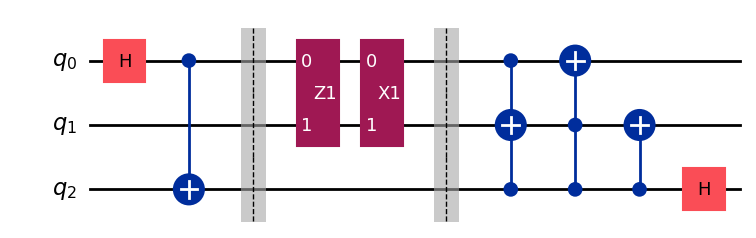

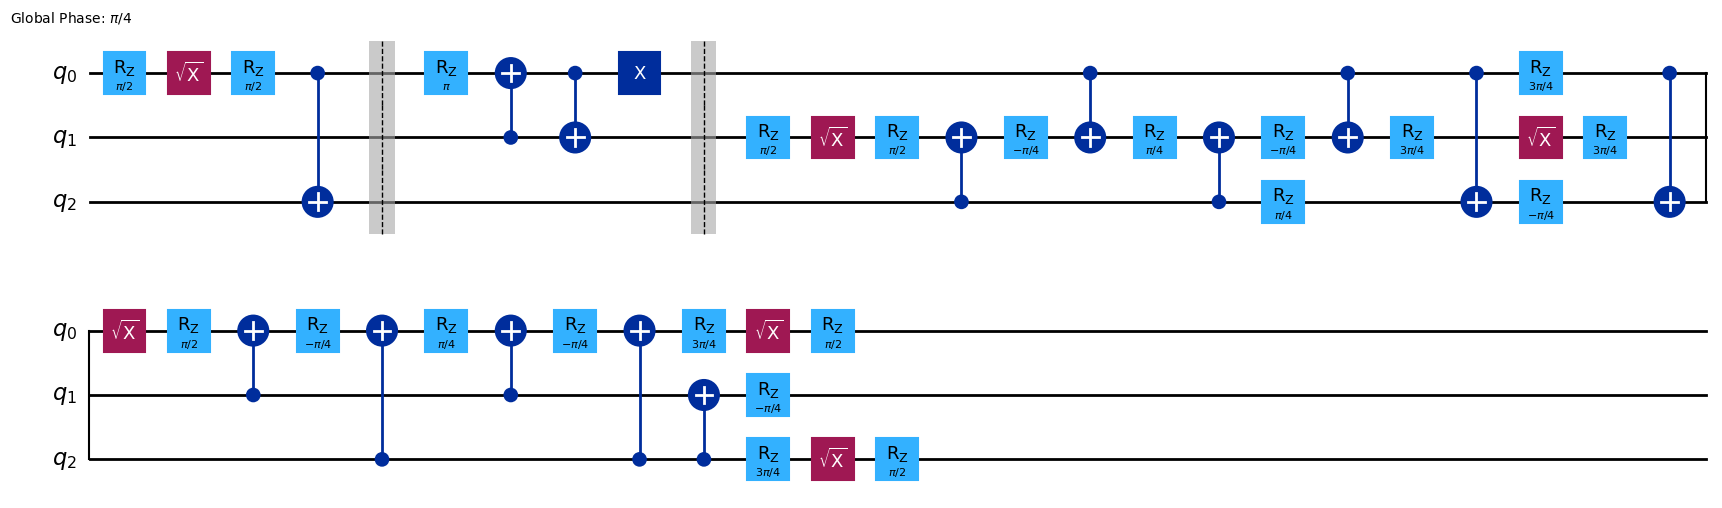

OrderedDict([('rz', 22), ('cx', 14), ('sx', 6), ('barrier', 2), ('x', 1)])
34


In [15]:
display(qc.draw('mpl'))

transpiled = transpile(qc, basis_gates=['rz', 'sx', 'x', 'cx'], optimization_level=3)
display(transpiled.draw('mpl'))
print(transpiled.count_ops())
print(transpiled.depth())

Measurement Counts: {'101': 10000}


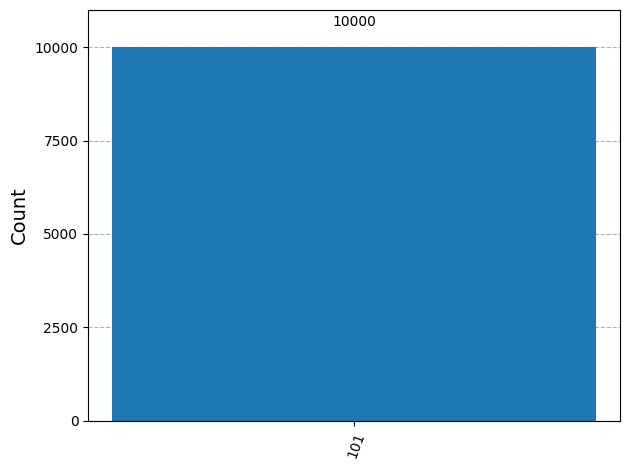

In [16]:
qc.measure_all()
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=10000).result()
counts = result.get_counts()

# Show results
print("Measurement Counts:", counts)
plot_histogram(counts)

## Run on Hardware

In [17]:
your_api_key = os.getenv("API_KEY_IBM")  #API Key Here
your_crn = os.getenv("CRN_IMB")          #CRN Here

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
)

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()
# Get a backend
backend = service.least_busy(operational=True, simulator=False)
print(f"We are using the {backend.name} quantum computer")
from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager

service = QiskitRuntimeService(name="qgss-2025")

sampler = Sampler(mode=backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)


job = sampler.run(pm.run([qc2]), shots=10000)

results_sampler = job.result()

counts =results_sampler[0].data.meas.get_counts()
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the histogram
plot_histogram(
        counts,
        title='Dense Coding Qubit Qubit',
        color='midnightblue',
        ax=ax
)
    
    # Add custom axis labels
ax.set_xlabel('Messages')
ax.set_ylabel('Counts')
    
    # Display the plot
plt.tight_layout()
display(fig)

InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got 'None'."